# Import Necessary Modules

In [4]:
__author__ = "Martin Mbaya"
!pip install -U -q PyDrive 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import linear_model, metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.test.gpu_device_name()

''

# Load Data from Google Drive

In [3]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile({'q': "'1_H-maiuG9bzIRPocVVuONmGaIw5KWUVp' in parents and trashed=false"}).GetList()
for file1 in file_list:
  f_holder = drive.CreateFile({'id': file1['id']})
  f_holder.GetContentFile(file1['title'])
  print('title: %s, id: %s' % (file1['title'], file1['id']))
  
  
kiva_loans = pd.read_csv("kiva_loans.csv")
kiva_mpi_region_locations = pd.read_csv("kiva_mpi_region_locations.csv") 
loan_theme_ids = pd.read_csv("loan_theme_ids.csv") 
loan_themes_by_region = pd.read_csv("loan_themes_by_region.csv")
    

title: loan_theme_ids.csv, id: 1IEkguTBV_nkWiVnkOMQQ_F_eCZFphETR
title: loan_themes_by_region.csv, id: 1MjzjJ2GoNE8sGNQObb4Lkm8gVjpfXthb
title: kiva_loans.csv, id: 1Sg463xEjvswu_YjVzZIRQBeVeGQiyarB
title: kiva_mpi_region_locations.csv, id: 1nle-bNa--Bd7eO61wQwU7_lketCjYorK


# Global Data Preprocessing

In [4]:
kiva_loans.columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_time', 'disbursed_time', 'funded_time', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date'],
      dtype='object')

*Drop repeated/unnecessarycolumns*

In [5]:
kiva_loans["time_to_fund"] = (pd.to_datetime(kiva_loans.funded_time) - pd.to_datetime(kiva_loans.disbursed_time))
kiva_loans = kiva_loans.drop(['posted_time','loan_amount','use','tags','disbursed_time', 'funded_time', 'date', 'currency'], axis=1)
kiva_loans.head()

,id,funded_amount,activity,sector,country_code,country,region,partner_id,term_in_months,lender_count,borrower_genders,repayment_interval,time_to_fund
0,653051,300.0,Fruits & Vegetables,Food,PK,Pakistan,Lahore,247.0,12.0,12,female,irregular,16 days 02:06:32
1,653053,575.0,Rickshaw,Transportation,PK,Pakistan,Lahore,247.0,11.0,14,"female, female",irregular,16 days 01:17:23
2,653068,150.0,Transportation,Transportation,IN,India,Maynaguri,334.0,43.0,6,female,bullet,15 days 08:01:36
3,653063,200.0,Embroidery,Arts,PK,Pakistan,Lahore,247.0,11.0,8,female,irregular,8 days 05:00:00
4,653084,400.0,Milk Sales,Food,PK,Pakistan,Abdul Hakeem,245.0,14.0,16,female,monthly,15 days 11:18:51


In [0]:
kiva_mpi_region_locations.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


In [6]:
kiva_mpi_region_locations = kiva_mpi_region_locations.dropna(thresh=2);
kiva_mpi_region_locations = kiva_mpi_region_locations.drop(['LocationName', 'lat', 'lon'], axis=1);
kiva_mpi_region_locations.head()

,ISO,country,region,world_region,MPI,geo
0,AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)"
1,AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)"
2,AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)"
3,AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)"
4,AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)"


In [0]:
loan_theme_ids.head()

,id,Loan Theme ID,Loan Theme Type,Partner ID
0,638631,a1050000000skGl,General,151.0
1,640322,a1050000000skGl,General,151.0
2,641006,a1050000002X1ij,Higher Education,160.0
3,641019,a1050000002X1ij,Higher Education,160.0
4,641594,a1050000002VbsW,Subsistence Agriculture,336.0


In [0]:
loan_themes_by_region.columns
loan_themes_by_region = loan_themes_by_region.drop(['Field Partner Name', 'sector', 'LocationName', 'lat', 'lon', 'names','mpi_region', 'geocode_old', 'geocode', 'mpi_geo'], axis=1)

In [0]:
loan_themes_by_region.head()

,Partner ID,Loan Theme ID,Loan Theme Type,country,forkiva,region,ISO,number,amount,geo,rural_pct
0,9,a1050000000slfi,Higher Education,Cambodia,No,Banteay Meanchey,KHM,1,450,"(13.6672596, 102.8975098)",90.0
1,9,a10500000068jPe,Vulnerable Populations,Cambodia,No,Battambang Province,KHM,58,20275,"(13.0286971, 102.989615)",90.0
2,9,a1050000000slfi,Higher Education,Cambodia,No,Battambang Province,KHM,7,9150,"(13.0286971, 102.989615)",90.0
3,9,a10500000068jPe,Vulnerable Populations,Cambodia,No,Kampong Cham Province,KHM,1383,604950,"(12.0982918, 105.3131185)",90.0
4,9,a1050000002X1Uu,Sanitation,Cambodia,No,Kampong Cham Province,KHM,3,275,"(12.0982918, 105.3131185)",90.0


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


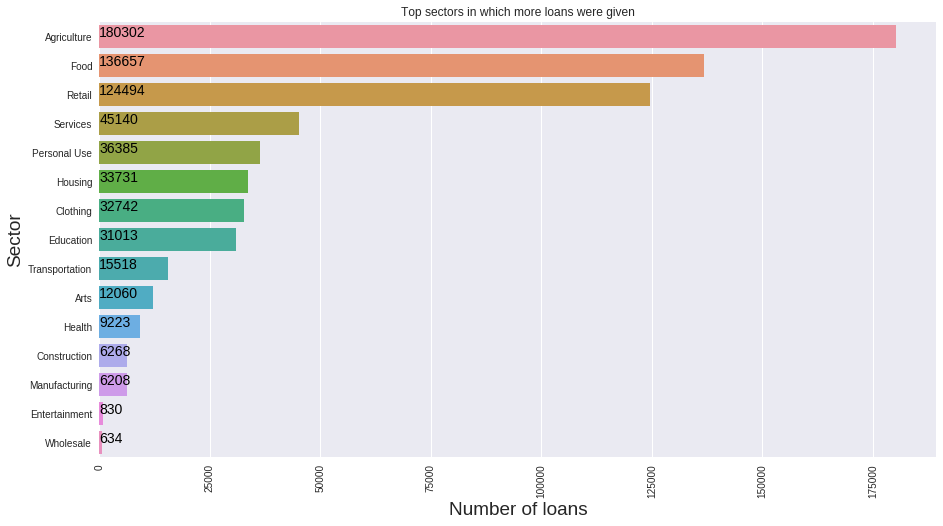

In [8]:
plt.figure(figsize=(15,8))
sector_name = kiva_loans['sector'].value_counts()
sns.barplot(sector_name.values, sector_name.index)
for i, v in enumerate(sector_name.values):
    plt.text(0.5,i,v,color='k',fontsize=14)
plt.xticks(rotation='vertical')
plt.xlabel('Number of loans', fontsize=19)
plt.ylabel('Sector', fontsize=19)
plt.title("Top sectors in which more loans were given")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Most frequent countries for kiva loan')

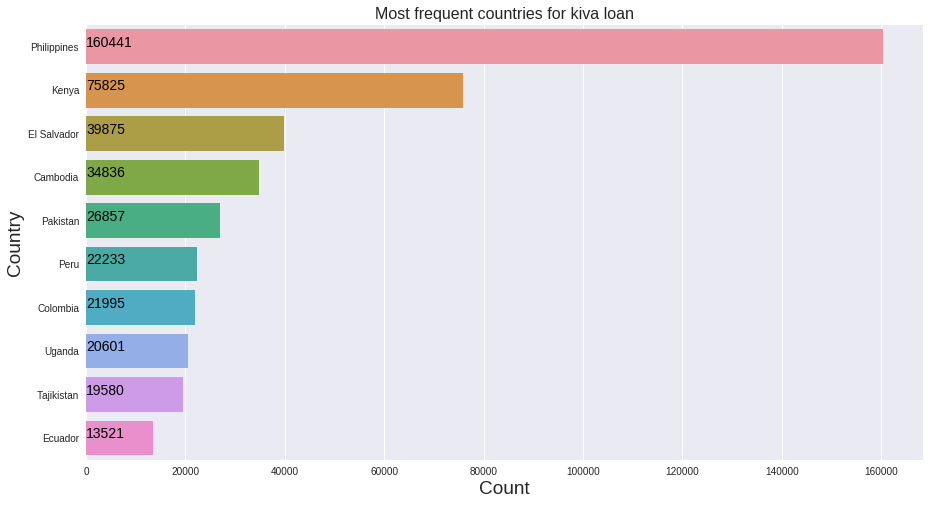

In [9]:
plt.figure(figsize=(15,8))
count = kiva_loans['country'].value_counts().head(10)
sns.barplot(count.values, count.index, )
for i, v in enumerate(count.values):
    plt.text(0.6,i,v,color='k',fontsize=14)
plt.xlabel('Count', fontsize=19)
plt.ylabel('Country', fontsize=19)
plt.title("Most frequent countries for kiva loan", fontsize=16)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Top Loan Activity type')

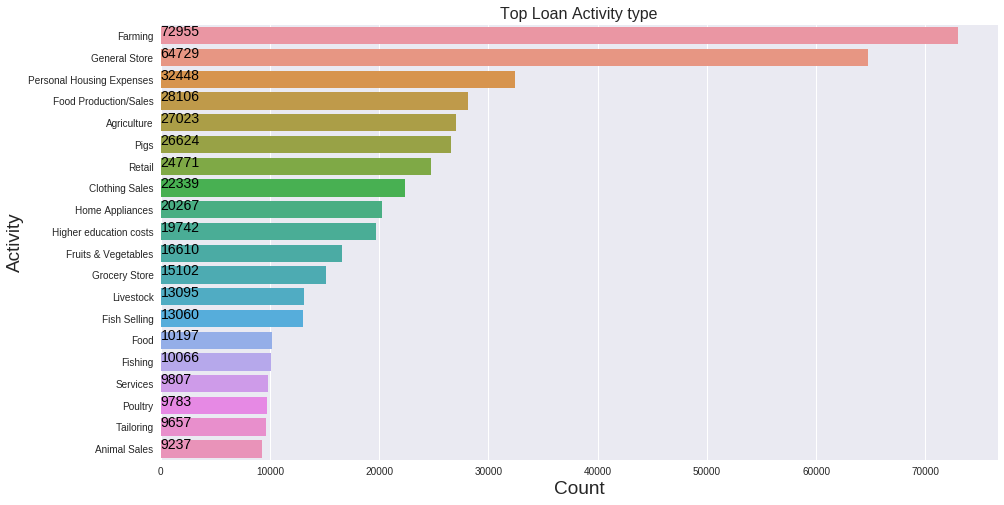

In [10]:
plt.figure(figsize=(15,8))
count = kiva_loans['activity'].value_counts().head(20)
sns.barplot(count.values, count.index)
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=14)
plt.xlabel('Count', fontsize=19)
plt.ylabel('Activity', fontsize=19)
plt.title("Top Loan Activity type", fontsize=16)

In [11]:
sector_repayment = ['country', 'repayment_interval']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(kiva_loans[sector_repayment[0]], kiva_loans[sector_repayment[1]]).style.background_gradient(cmap = cm)

repayment_interval,bullet,irregular,monthly,weekly
country,,,,
Afghanistan,2,0,0,0
Albania,23,26,1885,0
Armenia,43,170,8418,0
Azerbaijan,0,12,1933,0
Belize,0,0,125,0
Benin,1,40,456,0
Bhutan,0,2,0,0
Bolivia,39,1231,7536,0
Brazil,14,181,89,0


# Extract Kenya's data

In [0]:
kenya_loans = kiva_loans[(kiva_loans['country']=="Kenya") | (kiva_loans['country_code']=="KE")]

In [14]:
kenya_loans = kenya_loans.dropna()
# kenya_loans.describe()
kenya_loans.columns

Index(['id', 'funded_amount', 'activity', 'sector', 'country_code', 'country',
       'region', 'partner_id', 'term_in_months', 'lender_count',
       'borrower_genders', 'repayment_interval', 'time_to_fund'],
      dtype='object')

In [0]:
kiva_mpi_region_kenya = kiva_mpi_region_locations[(kiva_mpi_region_locations['country']=="Kenya") | (kiva_mpi_region_locations['ISO']=="KEN")]

In [21]:
kiva_mpi_region_kenya.head(10)

,ISO,country,region,world_region,MPI,geo
450,KEN,Kenya,Central,Sub-Saharan Africa,0.075,"(-4.0627412, 39.6771481)"
451,KEN,Kenya,Coast,Sub-Saharan Africa,0.242,"(-3.2096898, 40.1169399)"
452,KEN,Kenya,Eastern,Sub-Saharan Africa,0.190,"(0.7137256, 35.517938)"
453,KEN,Kenya,Nairobi,Sub-Saharan Africa,0.020,"(-1.2920659, 36.8219462)"
454,KEN,Kenya,North Eastern,Sub-Saharan Africa,0.509,"(-0.0190061, 37.6480812)"
455,KEN,Kenya,Nyanza,Sub-Saharan Africa,0.211,"(-1.2849963, 36.8272273)"
456,KEN,Kenya,Rift Valley,Sub-Saharan Africa,0.205,"(-18.382333, 47.2923893)"
457,KEN,Kenya,Western,Sub-Saharan Africa,0.223,"(-0.115003, 34.851379)"


In [0]:
set(kenya_loans.region);

In [0]:
kenya_loans.to_csv(path_or_buf = "kenya_loans.csv")
files.download('kenya_loans.csv')

The statement "set(kenya_loans.region);" was used to obtain unique locations in Kenya contained in the data.
This data was matched against the dataset - **kenya-poverty-metrics-by-district** and parameters such as *Poverty Gap*, *MPI*, *Severity of Poverty* were obtained.

The aim of doing this is to merge Kiva's data on Kenya and data from the **kenya-poverty-metrics-by-district** in order to come up with one dataset that can be used to create a model.

The model created using this compiled data(after training) would thereafter be used to estimate the poverty index. 

# Analysis on Kenya's data

In [62]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile({'q': "'1sLFU_eR_2d31kBVl60Wm9ztZ7dqKAAau' in parents and trashed=false"}).GetList()
for file1 in file_list:
  try:
    f_holder = drive.CreateFile({'id': file1['id']})
    f_holder.GetContentFile(file1['title'])
    print('title: %s, id: %s' % (file1['title'], file1['id']))
  except Exception as e:
    print(e)
  kenya_loans = pd.read_csv("kenya_loans.csv")
    

title: kenya_loans.csv, id: 1uWvHyvzxCp44Na38xwx3FLgDziAIM7kT
title: wb_subnational_poverty_data.csv, id: 1PHLWhaI0-EQ61GnwZ-77eI47TBZPp5Sy
title: Untitled.ipynb, id: 1ra_xxCVVoNK0jb_i0AHH5PLPvEo8pgBf
title: subnational_poverty_footnote.csv, id: 1FAH2ysuv8fXVSDaOAOPuNFZxivcUJ6xD
title: subnational_poverty_country.csv, id: 1sAAnalPC_hHqJMz-5TRvt7fIJ2FCcSkF
title: MPI_subnational.csv, id: 1P3Qc2g0f1FkDWtpsbU82vTeFeuhxJqgN
title: MPI_national.csv, id: 12Nk_U_5fRlfDNuQPqXctJfUHzPFguv-Z
No downloadLink/exportLinks for mimetype found in metadata
No downloadLink/exportLinks for mimetype found in metadata
No downloadLink/exportLinks for mimetype found in metadata
No downloadLink/exportLinks for mimetype found in metadata


# Data Preprocessing

In [51]:
# statistical summary of data
kenya_loans.describe()

,id,funded_amount,partner_id,term_in_months,lender_count,MPI,Poverty Gap,rural_pct,Severity of Poverty
count,6.183900e+04,61839.000000,61839.000000,61839.000000,61839.000000,61839.000000,61839.000000,60620.000000,61839.000000
mean,9.959779e+05,461.291418,181.976859,13.601465,14.017820,0.197718,9.241762,70.614748,3.621525
std,1.922022e+05,759.314374,75.812857,7.833545,22.328336,0.053038,4.200141,38.834722,2.090779
min,6.531570e+05,25.000000,133.000000,2.000000,1.000000,0.020000,2.400000,0.000000,0.500000
25%,8.399360e+05,225.000000,138.000000,11.000000,7.000000,0.205000,7.500000,65.000000,2.700000
50%,9.952440e+05,350.000000,156.000000,14.000000,10.000000,0.205000,9.100000,99.000000,3.400000
75%,1.174202e+06,550.000000,164.000000,14.000000,17.000000,0.223000,10.800000,99.000000,4.000000
max,1.335884e+06,50000.000000,529.000000,122.000000,1589.000000,0.509000,46.000000,99.000000,30.800000


**Remove rows with NA (blank) cells**

In [0]:
kenya_loans = kenya_loans.dropna()

In [53]:
kenya_loans.head()

,id,funded_amount,activity,sector,country_code,country,region,partner_id,term_in_months,lender_count,borrower_genders,repayment_interval,time_to_fund,MPI,Poverty Gap,Loan Theme ID,Loan Theme Type,For_Kiva,rural_pct,Severity of Poverty
0,653185,250,Fruits & Vegetables,Food,KE,Kenya,Voi,164,13,7,female,irregular,21 days 10:40:01.000000000,0.242,7.7,a1050000000wf14,General,No,99.0,2.7
1,653237,250,Cosmetics Sales,Retail,KE,Kenya,Likoni,164,14,3,female,irregular,26 days 23:33:21.000000000,0.242,7.5,a1050000000wf14,General,No,99.0,3.3
2,653229,250,Tailoring,Services,KE,Kenya,Likoni,164,14,1,female,irregular,24 days 13:56:07.000000000,0.242,7.5,a1050000000wf14,General,No,99.0,3.3
3,653247,250,Food Stall,Food,KE,Kenya,Voi,164,13,9,female,irregular,31 days 11:53:40.000000000,0.242,7.7,a1050000000wf14,General,No,99.0,2.7
4,653345,600,Fruits & Vegetables,Food,KE,Kenya,Likoni,164,14,22,female,irregular,25 days 14:25:13.000000000,0.242,7.5,a1050000000wf14,General,No,99.0,3.3


# **Visualize relationships in data**

In [0]:
data = kenya_loans
labels = data['Severity of Poverty']

Separate labels from the rest of the data

Text(0.5,1,'Correlation between different features')

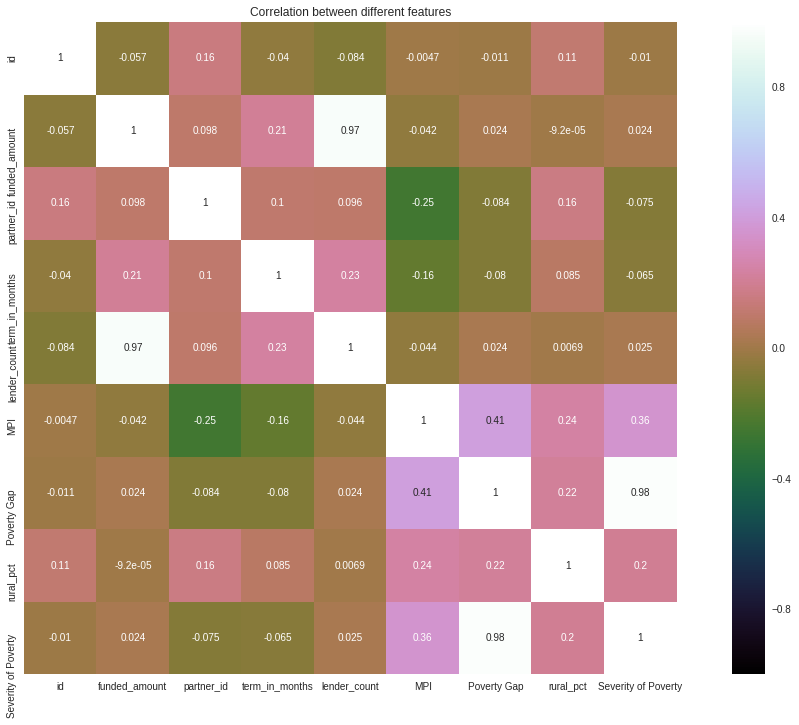

In [55]:
#Correlation Matrix
corr = data.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap='cubehelix', square=True)
plt.title('Correlation between different features')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Top 10 funded regions in Kenya')

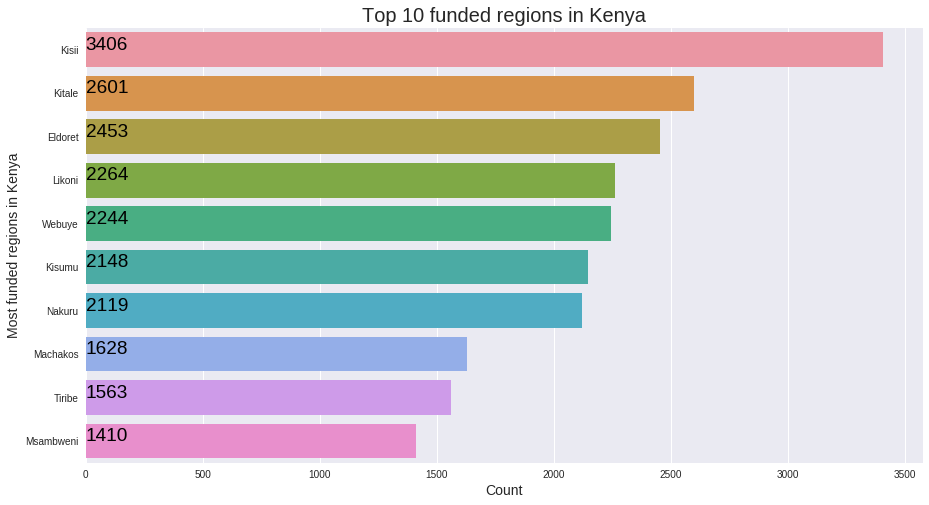

In [28]:
plt.figure(figsize=(15,8))
count = data['region'].value_counts().head(10)
sns.barplot(count.values, count.index)
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=19)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Most funded regions in Kenya', fontsize=14)
plt.title("Top 10 funded regions in Kenya", fontsize=20)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Top 10 funded sectorss in Kenya')

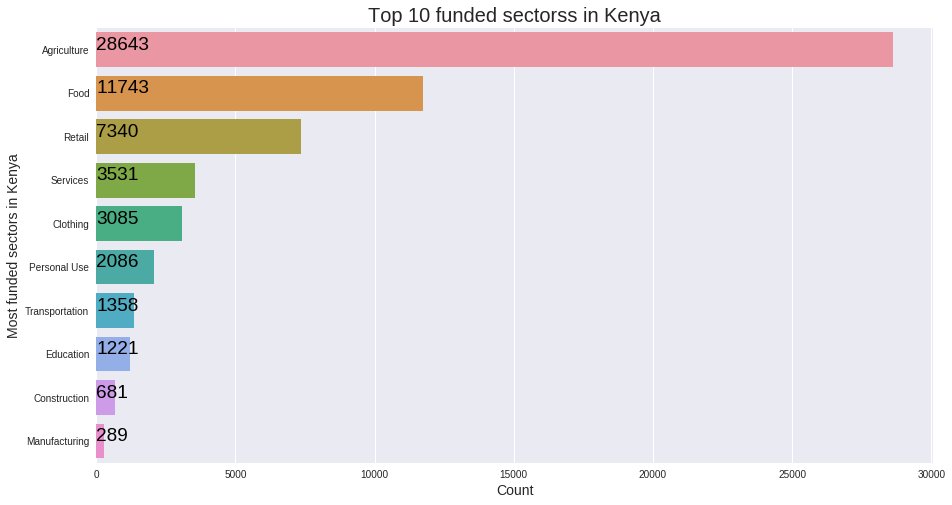

In [29]:
plt.figure(figsize=(15,8))
count = data['sector'].value_counts().head(10)
sns.barplot(count.values, count.index)
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=19)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Most funded sectors in Kenya', fontsize=14)
plt.title("Top 10 funded sectorss in Kenya", fontsize=20)

In [0]:
data['time_to_fund'] = [(int(i[:2])) for i in data.time_to_fund]
data = data.drop(['country_code', 'country', 'region'], axis=1)

*Drop columns with data that we'll not require to build a model*

In [66]:
len(set(data['borrower_genders']))


4689

*Notice how many unique values are contained in 'borrower_genders' column.
These would lead to many unnecessary columns being created after label encoding has been done*

In [0]:
data.borrower_genders = ["male" if i[0]=="m" else "female" for i in data.borrower_genders]

Reduce the number of unique gender values to "male" and "female"

In [0]:
set(data.activity);

In [0]:
data = data.drop(['id', 'activity','Severity of Poverty', 'Loan Theme ID'], axis=1)

In [69]:
data.head()

,funded_amount,sector,partner_id,term_in_months,lender_count,borrower_genders,repayment_interval,time_to_fund,MPI,Poverty Gap,Loan Theme Type,For_Kiva,rural_pct
0,250,Food,164,13,7,female,irregular,21,0.242,7.7,General,No,99.0
1,250,Retail,164,14,3,female,irregular,26,0.242,7.5,General,No,99.0
2,250,Services,164,14,1,female,irregular,24,0.242,7.5,General,No,99.0
3,250,Food,164,13,9,female,irregular,31,0.242,7.7,General,No,99.0
4,600,Food,164,14,22,female,irregular,25,0.242,7.5,General,No,99.0


**Perform one Hot encoding**

In [0]:
data = pd.get_dummies(data, prefix=['sector', 'sex', 'interv', 'theme'], columns=['sector', 'borrower_genders', 'repayment_interval', 'Loan Theme Type'])


Use label encoder to encode data contained in "For_Kiva" column

In [0]:
le = LabelEncoder()
data.For_Kiva = le.fit_transform(data.For_Kiva)

In [72]:
# print(data.head())
print(data.shape)


(60620, 54)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(48496, 54)
(12124, 54)
(48496,)
(12124,)


Split training and testing data

# Model Building

In [0]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)

In [0]:
y_pred = model.predict(X_test)

In [0]:
def accuracy_check(y_test, y_pred, tolerance):
  y_test = list(y_test)
  if len(y_test) != len(y_pred):
    return "Error! Y_test and Y_pred must be of equal size!"
  else:
    correct = 0.0
    for i in range(len(y_test)):
      error = abs(y_test[i] - y_pred[i])
      if error < tolerance:
        correct += 1
    return correct/len(y_test)

  


In [103]:
accuracy_check(y_test, y_pred, 0.5)

0.7881062355658198